### Diabetes dataset 

Number of Instances: 442

Features: 
- age: age in years
- sex: 1 - male | 2- female
- bmi: body mass index
- bp: average blood pressure
- s1: tc, total serum cholesterol
- s2: ldl, low-density lipoproteins
- s3: hdl, high-density lipoproteins
- s4: tch, total cholesterol / HDL
- s5: ltg, serum triglycerides level
- s6: glu, blood sugar level

Note that
> high-values of tc, ldl, and hdl is considered good or healthy, as these factors help to reduce choresterol level

> high-values of tch and ltg are considered bad or unhealthy

Output: Disease progression one year after the measures were taken - larger values indicate worst condition


The objective of this dataset is to predict the disease progression one year after based on some physological measurements. This is a regression problem. 

In [20]:
#load the data 
import sklearn.datasets
import pandas as pd
import numpy as np

data = pd.read_csv('diabetes.txt', sep='\t', lineterminator='\n')

data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [36]:
columns = list(data.columns)
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
pd.DataFrame(np.column_stack((columns[:-1],X.mean(axis=0),X.std(axis=0))), columns = ['Feature', 'Mean', 'Std'])

,Feature,Mean,Std
0,AGE,48.51809954751131,13.094190207980025
1,SEX,1.4683257918552035,0.4989957359922028
2,BMI,26.37579185520362,4.413120855492464
3,BP,94.64701357466062,13.815628311857534
4,S1,189.14027149321268,34.568880126921364
5,S2,115.43914027149322,30.378657550243798
6,S3,49.78846153846154,12.919562419379737
7,S4,4.070248868778281,1.288989285051803
8,S5,4.641410859728507,0.5217992869003063
9,S6,91.26018099547511,11.48332247173548


### The data is not normalized

## Attempt 1 - RandomForrest for regression 

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def adj_r2_score(r2_score, X): #function that computes the adjusted r2 score
    #get number of samples and regressor from X matrix
    N,k = X.shape
    
    return (1- ((1-r2_score)*(N-1)/(N-k-1)))

In [90]:
n_test = int(len(y)*.15)
n_train= len(y)-n_test
random_seed = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, test_size=n_test, random_state=random_seed)

rnd_clf = RandomForestRegressor(random_state=random_seed);
rnd_clf.fit(X_train,y_train)

RandomForestRegressor(random_state=32)

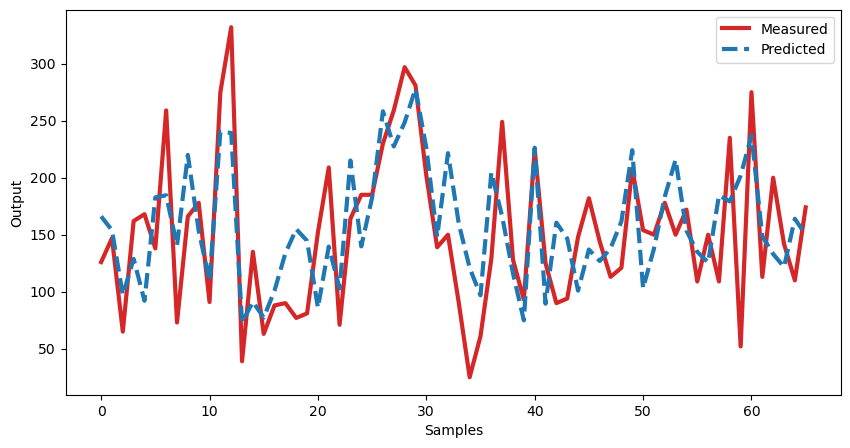

In [91]:
y_pred = rnd_clf.predict(X_test)
#plot the result
fig,ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(y_test, label= 'Measured', lw = 3, color='tab:red');
plt.plot(y_pred, '--', label= 'Predicted', lw = 3, color = 'tab:blue')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.legend()
plt.show();

In [74]:
#measures
RMSE = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
adj_r2 = adj_r2_score(r2,X_test)

print(f'RMSE = {RMSE} \nR2 Score = {r2} \nAdj R2 score = {adj_r2}')

RMSE = 2593.8422924242423 
R2 Score = 0.4162550159945355 
Adj R2 score = 0.31011956435717836


The R2 and adjusted R2 scores are below 0.5, indicating that the model is not doing a great job!

We can take a look at the important features!

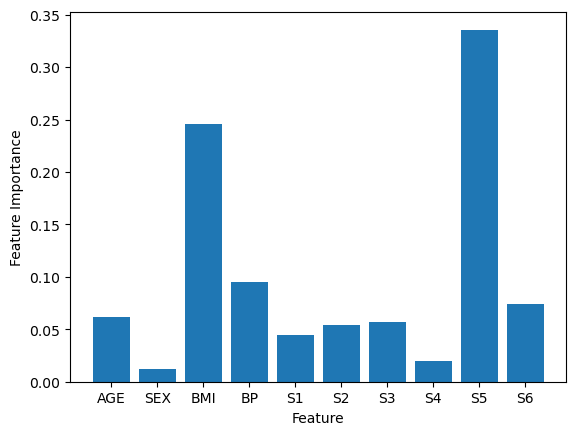

In [75]:
scores = []
names = []
for name, score in zip(columns[:-1], rnd_clf.feature_importances_):
    names.append(name)
    scores.append(score)
plt.bar(names,scores)
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.show()

clearly 
- Age
- S4 (total cholesterol)

appear not to be important features. We can take a look at a model without those features

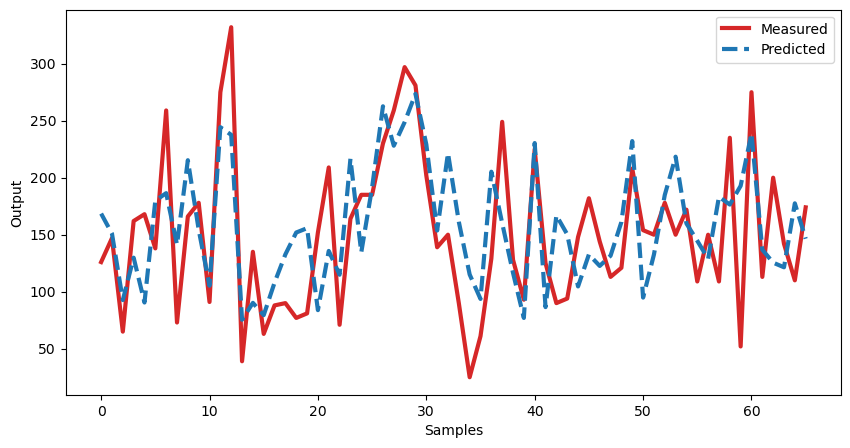

RMSE = 2693.915096969697 
R2 Score = 0.39373360138911206 
Adj R2 score = 0.2835033470962234


In [89]:
selected_columns = [0,2,3,4,5,6,8,9]

rnd_clf = RandomForestRegressor(random_state=random_seed);
rnd_clf.fit(X_train[:,selected_columns],y_train)
y_pred = rnd_clf.predict(X_test[:,selected_columns])
#plot the result
fig,ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(y_test, label= 'Measured', lw = 3, color='tab:red');
plt.plot(y_pred, '--', label= 'Predicted', lw = 3, color = 'tab:blue')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.legend()
plt.show();

#measures
RMSE = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
adj_r2 = adj_r2_score(r2,X_test)

print(f'RMSE = {RMSE} \nR2 Score = {r2} \nAdj R2 score = {adj_r2}')

Clearly, that didn't improve the model, meaning that those features are important for the model.

## Attempt 2 - Linear Model for Regression 

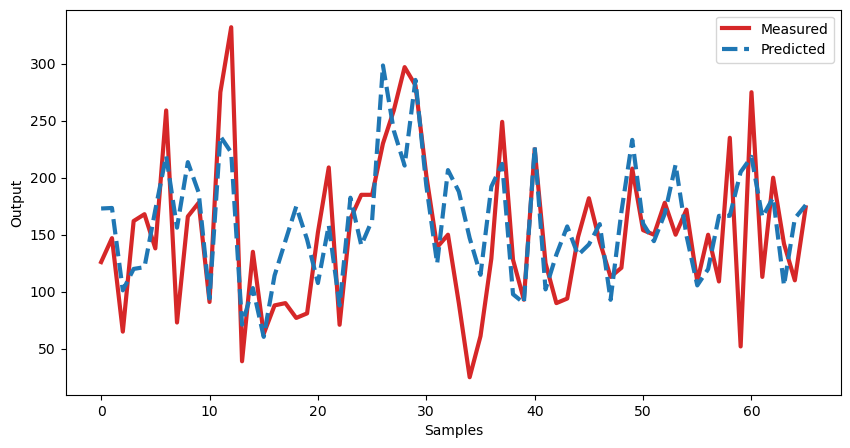

RMSE = 2570.6601501599303 
R2 Score = 0.42147216404737475 
Adj R2 score = 0.316285284783261


In [88]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#create pipeline that includes scaling and gradient descent
lin_reg = Pipeline([('scaler', StandardScaler()),
                ('SGD', SGDRegressor())])
#fit the model with data
lin_reg.fit(X_train,y_train);
y_pred = lin_reg.predict(X_test)

#plot the result
fig,ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(y_test, label= 'Measured', lw = 3, color='tab:red');
plt.plot(y_pred, '--', label= 'Predicted', lw = 3, color = 'tab:blue')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.legend()
plt.show();

#measures
RMSE = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
adj_r2 = adj_r2_score(r2,X_test)

print(f'RMSE = {RMSE} \nR2 Score = {r2} \nAdj R2 score = {adj_r2}')

### The scores are similar to those obtained for the RandomForrestModel!
With a bit lower RMSE


What can we learn from the linear model?

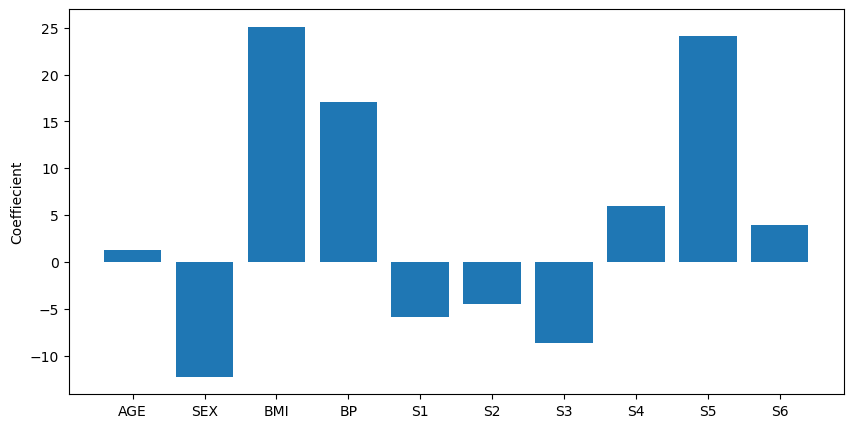

In [92]:
coefficients = lin_reg.named_steps['SGD'].coef_
fig,ax = plt.subplots(1,1,figsize=(10,5))
plt.bar(columns[:-1],coefficients)
#plt.xticks(range(len(coefficients)), features)
plt.ylabel('Coeffiecient')
plt.show();

What can we learn from our linear model?

BMI, BP and S5 (serum triglycerides level) are the most important features - Similar to the results provided by RandomForrest.

In addition, we can conclude that:

1. Larger BMI results in worst diabetic condition one year after -- makes sense? 
2. Larger blood pressure results in worst diabetic condition one year after -- makes sense?
3. Larger serum triglycerides level results in worst diabetic condition one year after -- makes sense?

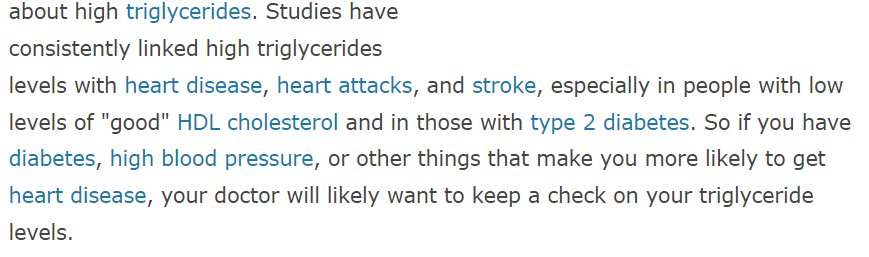

Furthermore, the model tell us that 

1. Larger high-density lipoproteins level results in better diabetic condition one year after -- makes sense?

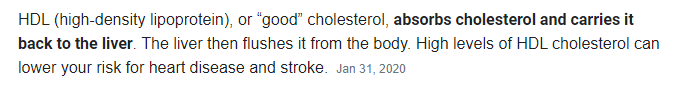

Finally, sex has a weird negative effect. What does it mean? 

In the original data, male sex had a value of 1 and female a value of 2. When we removed the mean, male sex resulted in a negative value and female in a positive value. Can you interprete the meaning of the **Sex** coefficient? 